<a href="https://colab.research.google.com/github/ZackPashkin/swin-transformer-pytorch-starter/blob/main/swin_transformer_pytorch_starter_wb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jul 20 13:19:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    39W / 300W |   1541MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# uncomment for the first run
!git clone https://github.com/microsoft/Swin-Transformer.git
!pip install timm
!wget https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth ./

In [ ]:
!pip install wandb -qqq
import wandb
# Log in to your W&B account
wandb.login()

True

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 30

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


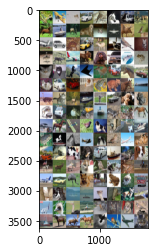

 frog plane  deer   car  bird horse truck  deer horse  ship  deer   dog  frog plane  deer  bird plane   car  frog   car  deer   cat  bird   cat  bird  deer plane horse   dog   car  ship  frog   cat   cat horse plane  deer   car horse   car   cat   car   car   dog  frog   cat horse  ship  bird   cat  deer  ship  bird   car   dog  frog truck truck  frog truck  ship   cat  deer horse  ship horse plane  bird   dog  bird   dog  ship  frog horse  deer plane   dog  bird plane   dog   car   dog   dog   dog   car  ship  frog   dog horse  deer truck   cat  bird  frog  frog horse plane   car  bird   cat  deer  frog   dog truck   cat   dog  ship  ship  bird  frog   dog plane plane  bird  bird plane  deer  deer   dog  bird  ship horse  deer horse  bird  bird plane   cat


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
%cd "/content/Swin-Transformer"
from models.swin_transformer import SwinTransformer
net = SwinTransformer(img_size=224,
                                patch_size=4,
                                in_chans=3,
                                num_classes=1000,
                                embed_dim=96,
                                depths=[2, 2, 6, 2],
                                num_heads=[ 3, 6, 12, 24 ],
                                window_size=7,
                                mlp_ratio=4.,
                                qkv_bias=True,
                                qk_scale=True,
                                drop_rate=0.0,
                                drop_path_rate=0.2,
                                ape=False,
                                patch_norm=True,
                                use_checkpoint=True)

net.load_state_dict(torch.load('/content/swin_tiny_patch4_window7_224.pth')['model'],strict=True)
net.head = nn.Linear(net.head.in_features, 10)

dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x) 
net = net.to(device)
print(logits.shape)
print(net.head.bias.shape)

/content/Swin-Transformer
torch.Size([1, 10])
torch.Size([10])


In [ ]:
# model description
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict
import numpy as np

model = net
input_size = (3,224,224)
batch_size= 128
device="cuda"

def register_hook(module):

    def hook(module, input, output):
        class_name = str(module.__class__).split(".")[-1].split("'")[0]
        module_idx = len(summary)

        m_key = "%s-%i" % (class_name, module_idx + 1)
        summary[m_key] = OrderedDict()
        summary[m_key]["input_shape"] = list(input[0].size())
        summary[m_key]["input_shape"][0] = batch_size
        if isinstance(output, (list, tuple)):
            summary[m_key]["output_shape"] = [
                [-1] + list(o.size())[1:] for o in output
            ]
        else:
            summary[m_key]["output_shape"] = list(output.size())
            summary[m_key]["output_shape"][0] = batch_size

        params = 0
        if hasattr(module, "weight") and hasattr(module.weight, "size"):
            params += torch.prod(torch.LongTensor(list(module.weight.size())))
            summary[m_key]["trainable"] = module.weight.requires_grad
        if hasattr(module, "bias") and hasattr(module.bias, "size"):
            params += torch.prod(torch.LongTensor(list(module.bias.size())))
        summary[m_key]["nb_params"] = params

    if (
        not isinstance(module, nn.Sequential)
        and not isinstance(module, nn.ModuleList)
        and not (module == model)
    ):
        hooks.append(module.register_forward_hook(hook))

device = device.lower()
assert device in [
    "cuda",
    "cpu",
], "Input device is not valid, please specify 'cuda' or 'cpu'"

if device == "cuda" and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# multiple inputs to the network
if isinstance(input_size, tuple):
    input_size = [input_size]

# batch_size of 2 for batchnorm
x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
# print(type(x[0]))

# create properties
summary = OrderedDict()
hooks = []

# register hook
model.apply(register_hook)

# make a forward pass
# print(x.shape)
model(*x)

# remove these hooks
for h in hooks:
    h.remove()

print("----------------------------------------------------------------")
line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
print(line_new)
print("================================================================")
total_params = 0
total_output = 0
trainable_params = 0
for layer in summary:
    # input_shape, output_shape, trainable, nb_params
    line_new = "{:>20}  {:>25} {:>15}".format(
        layer,
        str(summary[layer]["output_shape"]),
        "{0:,}".format(summary[layer]["nb_params"]),
    )
    total_params += summary[layer]["nb_params"]
    total_output += np.prod(summary[layer]["output_shape"])
    if "trainable" in summary[layer]:
        if summary[layer]["trainable"] == True:
            trainable_params += summary[layer]["nb_params"]
    print(line_new)

# assume 4 bytes/number (float on cuda).
total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
total_size = total_params_size + total_output_size + total_input_size


summary_df = pd.DataFrame({"Total params": int(total_params),
                   "Trainable params": int(trainable_params),
                   "Non-trainable params": int(total_params - trainable_params),
                   "Input size (MB)": total_input_size,
                   "Forward/backward pass size (MB)":total_output_size,
                   "Params size (MB)":total_params_size,
                   "Estimated Total Size (MB)": total_size},index=[0]).reset_index(drop=True).T

summary_df

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 96, 56, 56]           4,704
         LayerNorm-2            [128, 3136, 96]             192
        PatchEmbed-3            [128, 3136, 96]               0
           Dropout-4            [128, 3136, 96]               0
         LayerNorm-5            [128, 3136, 96]             192
            Linear-6             [128, 49, 288]          27,936
           Softmax-7           [128, 3, 49, 49]               0
           Dropout-8           [128, 3, 49, 49]               0
            Linear-9              [128, 49, 96]           9,312
          Dropout-10              [128, 49, 96]               0
  WindowAttention-11              [128, 49, 96]               0
         Identity-12            [128, 3136, 96]               0
        LayerNorm-13            [128, 3136, 96]             192
           Linear-14           [128, 31

,0
Total params,2.750372e+07
Trainable params,2.750372e+07
Non-trainable params,0.000000e+00
Input size (MB),7.350000e+01
Forward/backward pass size (MB),3.238153e+04
Params size (MB),1.049184e+02
Estimated Total Size (MB),3.255995e+04


In [ ]:
import torch.optim as optim
lr = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [ ]:
# Start a run, tracking hyperparameters
wandb.init(
  project="resnet50 vs swin transformer tiny",
  config={
      "summary": summary_df,
      "optimizer": optimizer,
      "loss": criterion,
      "learning rate": lr,
      "metric": "accuracy",
      "epoch": epochs,
      "batch_size": batch_size,
  })
config = wandb.config

In [ ]:
from tqdm.notebook import tqdm
from time import time

for epoch in tqdm(range(epochs), "Epoch: "): 
    net.train()
    optimizer.zero_grad()

    start = time()


    running_loss = 0.0
    tqdm_train = tqdm(enumerate(trainloader, 0), "Train step: ", total=len(trainloader))
    for i, data in tqdm_train:

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        tqdm_train.set_postfix(loss=loss.item())
        

    
    epoch_time = time() - start
    print(f"Epoch time: {epoch_time/60:.3f} min" )
    print(f"Epoch {epoch + 1} Train loss: {running_loss / len(trainloader):.3f}")
    len_trainloader = len(trainloader)
    wandb.log({"Epoch":epoch + 1,
               "Epoch time": epoch_time/60,
               "Train loss":running_loss/len_trainloader,
               })
    
    running_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        net.eval()
        tqdm_val = tqdm(enumerate(valloader, 0), "Val step: ", total=len(valloader))
        for i, data in tqdm_val:
            inputs, labels = data[0].to(device), data[1].to(device)  
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # print statistics
            running_loss += loss.item()
            tqdm_val.set_postfix(loss=loss.item())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in list(zip(labels, predictions)):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1 
               
    # print accuracy for each class
    accuracy_sum = []
    classnames = []
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        accuracy_sum.append(accuracy)
        classnames.append(classname)
        print(f"Accuracy for class {classname}: {accuracy:.1f}%")  
        
    classnames_accuracy = list(zip(classnames,accuracy_sum))
    print(f"Epoch {epoch + 1} Val loss: {running_loss / len(valloader):.3f}")
    print(f"Total accuracy: {sum(accuracy_sum)/len(accuracy_sum)}")
    len_valloader = len(valloader)
    wandb.log({"Epoch":epoch + 1, 
               "Val loss":running_loss / len_valloader,
               "Accuracy by class": classnames_accuracy,
               "Total accuracy": sum(accuracy_sum)/len(accuracy_sum),
               })

# Mark the run as finished
wandb.finish()
print('Training comleted')


Epoch time: 5.251 min
Epoch 1 Train loss: 2.085


/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Accuracy for class plane: 46.6%
Accuracy for class car: 38.5%
Accuracy for class bird: 17.2%
Accuracy for class cat: 11.6%
Accuracy for class deer: 21.9%
Accuracy for class dog: 55.4%
Accuracy for class frog: 32.9%
Accuracy for class horse: 38.0%
Accuracy for class ship: 33.8%
Accuracy for class truck: 42.7%
Epoch 1 Val loss: 1.758
Total accuracy: 33.86



Epoch time: 5.275 min
Epoch 2 Train loss: 1.691



Accuracy for class plane: 52.3%
Accuracy for class car: 62.1%
Accuracy for class bird: 29.6%
Accuracy for class cat: 28.5%
Accuracy for class deer: 42.4%
Accuracy for class dog: 51.4%
Accuracy for class frog: 64.4%
Accuracy for class horse: 50.3%
Accuracy for class ship: 67.4%
Accuracy for class truck: 34.0%
Epoch 2 Val loss: 1.426
Total accuracy: 48.24000000000001



Epoch time: 5.299 min
Epoch 3 Train loss: 1.306



Accuracy for class plane: 66.3%
Accuracy for class car: 81.5%
Accuracy for class bird: 59.8%
Accuracy for class cat: 60.3%
Accuracy for class deer: 51.1%
Accuracy for class dog: 54.6%
Accuracy for class frog: 62.3%
Accuracy for class horse: 70.1%
Accuracy for class ship: 78.1%
Accuracy for class truck: 72.6%
Epoch 3 Val loss: 0.973
Total accuracy: 65.67000000000002



Epoch time: 5.288 min
Epoch 4 Train loss: 0.897



Accuracy for class plane: 86.5%
Accuracy for class car: 89.3%
Accuracy for class bird: 66.9%
Accuracy for class cat: 61.3%
Accuracy for class deer: 83.1%
Accuracy for class dog: 74.9%
Accuracy for class frog: 84.3%
Accuracy for class horse: 80.4%
Accuracy for class ship: 82.8%
Accuracy for class truck: 90.7%
Epoch 4 Val loss: 0.590
Total accuracy: 80.02



Epoch time: 5.284 min
Epoch 5 Train loss: 0.581



Accuracy for class plane: 86.8%
Accuracy for class car: 96.1%
Accuracy for class bird: 80.6%
Accuracy for class cat: 80.4%
Accuracy for class deer: 89.4%
Accuracy for class dog: 87.3%
Accuracy for class frog: 89.6%
Accuracy for class horse: 90.8%
Accuracy for class ship: 92.8%
Accuracy for class truck: 91.2%
Epoch 5 Val loss: 0.351
Total accuracy: 88.49999999999999



Epoch time: 5.283 min
Epoch 6 Train loss: 0.390



Accuracy for class plane: 90.9%
Accuracy for class car: 95.8%
Accuracy for class bird: 91.3%
Accuracy for class cat: 81.4%
Accuracy for class deer: 90.0%
Accuracy for class dog: 90.3%
Accuracy for class frog: 90.6%
Accuracy for class horse: 93.9%
Accuracy for class ship: 94.3%
Accuracy for class truck: 95.3%
Epoch 6 Val loss: 0.249
Total accuracy: 91.37999999999998



Epoch time: 5.281 min
Epoch 7 Train loss: 0.309



Accuracy for class plane: 95.3%
Accuracy for class car: 95.1%
Accuracy for class bird: 91.3%
Accuracy for class cat: 80.3%
Accuracy for class deer: 90.3%
Accuracy for class dog: 93.1%
Accuracy for class frog: 95.7%
Accuracy for class horse: 94.7%
Accuracy for class ship: 95.1%
Accuracy for class truck: 96.0%
Epoch 7 Val loss: 0.211
Total accuracy: 92.69000000000001



Epoch time: 5.277 min
Epoch 8 Train loss: 0.253



Accuracy for class plane: 93.5%
Accuracy for class car: 98.4%
Accuracy for class bird: 93.3%
Accuracy for class cat: 86.7%
Accuracy for class deer: 92.7%
Accuracy for class dog: 90.9%
Accuracy for class frog: 97.2%
Accuracy for class horse: 96.3%
Accuracy for class ship: 96.8%
Accuracy for class truck: 95.1%
Epoch 8 Val loss: 0.181
Total accuracy: 94.09



Epoch time: 5.283 min
Epoch 9 Train loss: 0.223



Accuracy for class plane: 95.1%
Accuracy for class car: 97.6%
Accuracy for class bird: 92.0%
Accuracy for class cat: 85.9%
Accuracy for class deer: 93.8%
Accuracy for class dog: 92.7%
Accuracy for class frog: 97.5%
Accuracy for class horse: 94.5%
Accuracy for class ship: 97.5%
Accuracy for class truck: 94.9%
Epoch 9 Val loss: 0.172
Total accuracy: 94.15



Epoch time: 5.275 min
Epoch 10 Train loss: 0.198



Accuracy for class plane: 96.4%
Accuracy for class car: 98.6%
Accuracy for class bird: 95.8%
Accuracy for class cat: 88.4%
Accuracy for class deer: 94.7%
Accuracy for class dog: 91.8%
Accuracy for class frog: 95.9%
Accuracy for class horse: 95.1%
Accuracy for class ship: 95.2%
Accuracy for class truck: 95.6%
Epoch 10 Val loss: 0.159
Total accuracy: 94.75000000000001



Epoch time: 5.281 min
Epoch 11 Train loss: 0.180



Accuracy for class plane: 97.2%
Accuracy for class car: 98.0%
Accuracy for class bird: 91.6%
Accuracy for class cat: 89.5%
Accuracy for class deer: 95.1%
Accuracy for class dog: 93.1%
Accuracy for class frog: 96.7%
Accuracy for class horse: 95.3%
Accuracy for class ship: 95.2%
Accuracy for class truck: 96.9%
Epoch 11 Val loss: 0.155
Total accuracy: 94.86



Epoch time: 5.276 min
Epoch 12 Train loss: 0.160



Accuracy for class plane: 95.5%
Accuracy for class car: 98.2%
Accuracy for class bird: 94.1%
Accuracy for class cat: 88.9%
Accuracy for class deer: 95.8%
Accuracy for class dog: 93.9%
Accuracy for class frog: 98.5%
Accuracy for class horse: 93.7%
Accuracy for class ship: 97.9%
Accuracy for class truck: 96.0%
Epoch 12 Val loss: 0.145
Total accuracy: 95.25



Epoch time: 5.273 min
Epoch 13 Train loss: 0.147



Accuracy for class plane: 95.0%
Accuracy for class car: 98.2%
Accuracy for class bird: 94.9%
Accuracy for class cat: 89.1%
Accuracy for class deer: 93.3%
Accuracy for class dog: 93.5%
Accuracy for class frog: 98.2%
Accuracy for class horse: 96.3%
Accuracy for class ship: 97.3%
Accuracy for class truck: 96.6%
Epoch 13 Val loss: 0.136
Total accuracy: 95.24



Epoch time: 5.278 min
Epoch 14 Train loss: 0.137



Accuracy for class plane: 97.1%
Accuracy for class car: 98.6%
Accuracy for class bird: 94.5%
Accuracy for class cat: 87.9%
Accuracy for class deer: 95.3%
Accuracy for class dog: 94.7%
Accuracy for class frog: 97.1%
Accuracy for class horse: 96.2%
Accuracy for class ship: 96.2%
Accuracy for class truck: 96.9%
Epoch 14 Val loss: 0.136
Total accuracy: 95.45000000000002



Epoch time: 5.281 min
Epoch 15 Train loss: 0.122



Accuracy for class plane: 97.9%
Accuracy for class car: 98.7%
Accuracy for class bird: 93.4%
Accuracy for class cat: 90.4%
Accuracy for class deer: 95.3%
Accuracy for class dog: 93.2%
Accuracy for class frog: 98.4%
Accuracy for class horse: 96.6%
Accuracy for class ship: 96.2%
Accuracy for class truck: 95.9%
Epoch 15 Val loss: 0.141
Total accuracy: 95.6


In [ ]:
# gpu load  7107MiB

In [ ]:
PATH = './model.pt'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Note: 
## model specs

Total params: 27,486,250

Trainable params: 27,486,250

Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57

Forward/backward pass size (MB): 269.03

Params size (MB): 104.85

Estimated Total Size (MB): 374.45


See available weights here https://github.com/microsoft/Swin-Transformer



# Reference


https://github.com/sksq96/pytorch-summary#multiple-inputs

https://github.com/berniwal/swin-transformer-pytorch

https://arxiv.org/pdf/2103.14030.pdf